In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from collections import deque
import cv2
import imageio
import ale_py
import shimmy


In [42]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
LR = 0.00025
GAMMA = 0.99
REPLAY_START_SIZE = 5000
MEMORY_CAPACITY = 200_000
TARGET_UPDATE_FREQ = 10000
EPSILON_START = 0.5
EPSILON_END = 0.1
EPSILON_DECAY_FRAMES = 1000000


env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
NUM_ACTIONS = env.action_space.n
NUM_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape

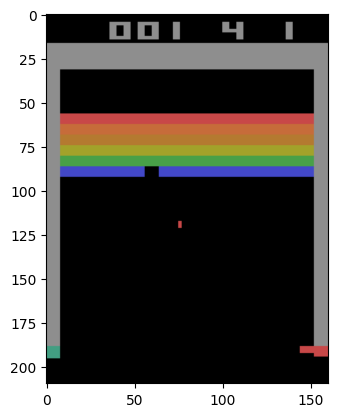

In [8]:
# Check environment
import gymnasium as gym
from IPython import display
import matplotlib.pyplot as plt

observation = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    img = plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if not done:
        img.remove()

env.close()

In [43]:

def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 110), interpolation=cv2.INTER_AREA)
    frame = frame[18:102, :]
    return frame.astype(np.uint8)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((
            torch.tensor(state, dtype=torch.uint8),
            torch.tensor(action, dtype=torch.int64),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(next_state, dtype=torch.uint8),
            torch.tensor(done, dtype=torch.float32)
        ))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state = torch.stack([b[0].float() / 255.0 for b in batch]).to(DEVICE)
        action = torch.stack([b[1] for b in batch]).to(DEVICE)
        reward = torch.stack([b[2] for b in batch]).to(DEVICE)
        next_state = torch.stack([b[3].float() / 255.0 for b in batch]).to(DEVICE)
        done = torch.stack([b[4] for b in batch]).to(DEVICE)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

class CNNNet(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

class DQNAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.eval_net = CNNNet(action_size).to(DEVICE)
        self.target_net = CNNNet(action_size).to(DEVICE)
        self.target_net.load_state_dict(self.eval_net.state_dict())
        self.optimizer = optim.AdamW(self.eval_net.parameters(), lr=LR) 
        self.memory = ReplayBuffer(MEMORY_CAPACITY)
        self.steps_done = 0
    def epsilon_by_frame(self, frame_idx):
        epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * max(0, (EPSILON_DECAY_FRAMES - frame_idx) / EPSILON_DECAY_FRAMES)
        return epsilon
    def select_action(self, state, epsilon=None):
        self.steps_done += 1
        if epsilon is None:
            epsilon = self.epsilon_by_frame(self.steps_done)

        if random.random() > epsilon:
            with torch.no_grad():
                state_tensor = torch.tensor(state, device=DEVICE).unsqueeze(0).float() / 255.0
                q_values = self.eval_net(state_tensor)
                return q_values.argmax(dim=1).item()
        else:
            return random.randrange(self.action_size)

    def select_action(self, state, epsilon=None):
        self.steps_done += 1
        if epsilon is None:
            epsilon = self.epsilon_by_frame(self.steps_done)

        if random.random() > epsilon:
            with torch.no_grad():
                state_tensor = torch.tensor(state, device=DEVICE).unsqueeze(0).float() / 255.0
                q_values = self.eval_net(state_tensor)
                return q_values.argmax(dim=1).item()
        else:
            return random.randrange(self.action_size)

    def optimize_model(self):
        if len(self.memory) < REPLAY_START_SIZE:
            return None

        state, action, reward, next_state, done = self.memory.sample(BATCH_SIZE)

        q_values = self.eval_net(state).gather(1, action.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_actions = self.eval_net(next_state).argmax(1)
            next_q_values = self.target_net(next_state).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            expected_q = reward + GAMMA * next_q_values * (1 - done)
    
        loss = F.smooth_l1_loss(q_values, expected_q)
    
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.eval_net.parameters(), 10)
        self.optimizer.step()
    
        return loss.item()


In [44]:

def train(agent, env_name="ALE/Breakout-v5", episodes=500, print_every=20, save_every=100, succ_stopping=30):
    env = gym.make(env_name, render_mode='rgb_array')
    episode_rewards = []
    losses = []
    num_of_succeeds = 0

    for n_epi in range(episodes):
        state, _ = env.reset()
        state = preprocess_frame(state)
        state_stack = np.stack([state] * 4, axis=0)

        total_reward = 0
        done = False
        # epsilon = max(0.05, 0.25 * np.exp(-1.5 * n_epi / 500))
        epsilon = agent.epsilon_by_frame(agent.steps_done)

        while not done:
            action = agent.select_action(state_stack, epsilon=epsilon)
            next_state_raw, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            reward = np.clip(reward, -1, 1)
            next_state_processed = preprocess_frame(next_state_raw)
            next_state_stack = np.roll(state_stack, shift=-1, axis=0)
            next_state_stack[-1] = next_state_processed

            agent.memory.push(
            state_stack,
            action,
            float(reward),
            next_state_stack,
            float(done)
        )
            state_stack = next_state_stack
            total_reward += reward

            loss = agent.optimize_model()
            if loss is not None:
                losses.append(loss)

            if agent.steps_done % TARGET_UPDATE_FREQ == 0:
                agent.target_net.load_state_dict(agent.eval_net.state_dict())

        episode_rewards.append(total_reward)


        if n_epi % print_every == 0 or done:
            avg_reward = np.mean(episode_rewards[-10:])
            print(
                f"Episode {n_epi} | "
                f"Total Reward: {total_reward} | "
                f"Buffer size: {len(agent.memory)} | "
                f"Epsilon: {epsilon*100:.1f}% | "
                f"Total Steps: {agent.steps_done} /"
                f"Awg reward: {avg_reward}"

            )


        if n_epi % save_every == 0 and n_epi > 0:
            torch.save({
                'eval_net': agent.eval_net.state_dict(),
                'target_net': agent.target_net.state_dict(),
                'optimizer': agent.optimizer.state_dict(),
                'steps_done': agent.steps_done
            }, 'agent_checkpoint_900.pt')
            print(f"Checkpoint saved: target_net_breakout_{n_epi}.pt")

        if truncated:
            num_of_succeeds += 1

        if num_of_succeeds >= succ_stopping:
            print(f"Succeeded {num_of_succeeds} times! Training Stopped.")
            break

    env.close()
    return episode_rewards, losses


def plot_training_results(rewards, losses):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    ax[0].set_title("Total Rewards per Episode")
    ax[0].plot(rewards)
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Reward")

    ax[1].set_title("Loss Curve")
    ax[1].plot(losses)
    ax[1].set_xlabel("Training Step")
    ax[1].set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

In [25]:
agent = DQNAgent(action_size=4) 

agent.target_net.load_state_dict(torch.load("target_net_breakout_1500.pt"))

<All keys matched successfully>

In [32]:
import time
torch.cuda.empty_cache()

rewards, losses = train(agent)


Episode 0 | Total Reward: 1.0 | Buffer size: 150 | Epsilon: 50.0% | Total Steps: 150 /Awg reward: 1.0
Episode 1 | Total Reward: 2.0 | Buffer size: 332 | Epsilon: 50.0% | Total Steps: 332 /Awg reward: 1.5
Episode 2 | Total Reward: 2.0 | Buffer size: 554 | Epsilon: 50.0% | Total Steps: 554 /Awg reward: 1.6666666666666667
Episode 3 | Total Reward: 0.0 | Buffer size: 680 | Epsilon: 50.0% | Total Steps: 680 /Awg reward: 1.25
Episode 4 | Total Reward: 2.0 | Buffer size: 901 | Epsilon: 50.0% | Total Steps: 901 /Awg reward: 1.4
Episode 5 | Total Reward: 3.0 | Buffer size: 1147 | Epsilon: 50.0% | Total Steps: 1147 /Awg reward: 1.6666666666666667
Episode 6 | Total Reward: 2.0 | Buffer size: 1347 | Epsilon: 50.0% | Total Steps: 1347 /Awg reward: 1.7142857142857142
Episode 7 | Total Reward: 1.0 | Buffer size: 1503 | Epsilon: 49.9% | Total Steps: 1503 /Awg reward: 1.625
Episode 8 | Total Reward: 0.0 | Buffer size: 1626 | Epsilon: 49.9% | Total Steps: 1626 /Awg reward: 1.4444444444444444
Episode 9 |

In [ ]:
torch.save(agent.target_net.state_dict(), "target_last.pt")

In [ ]:
torch.cuda.empty_cache()

rewards2, losses2 = train(agent)

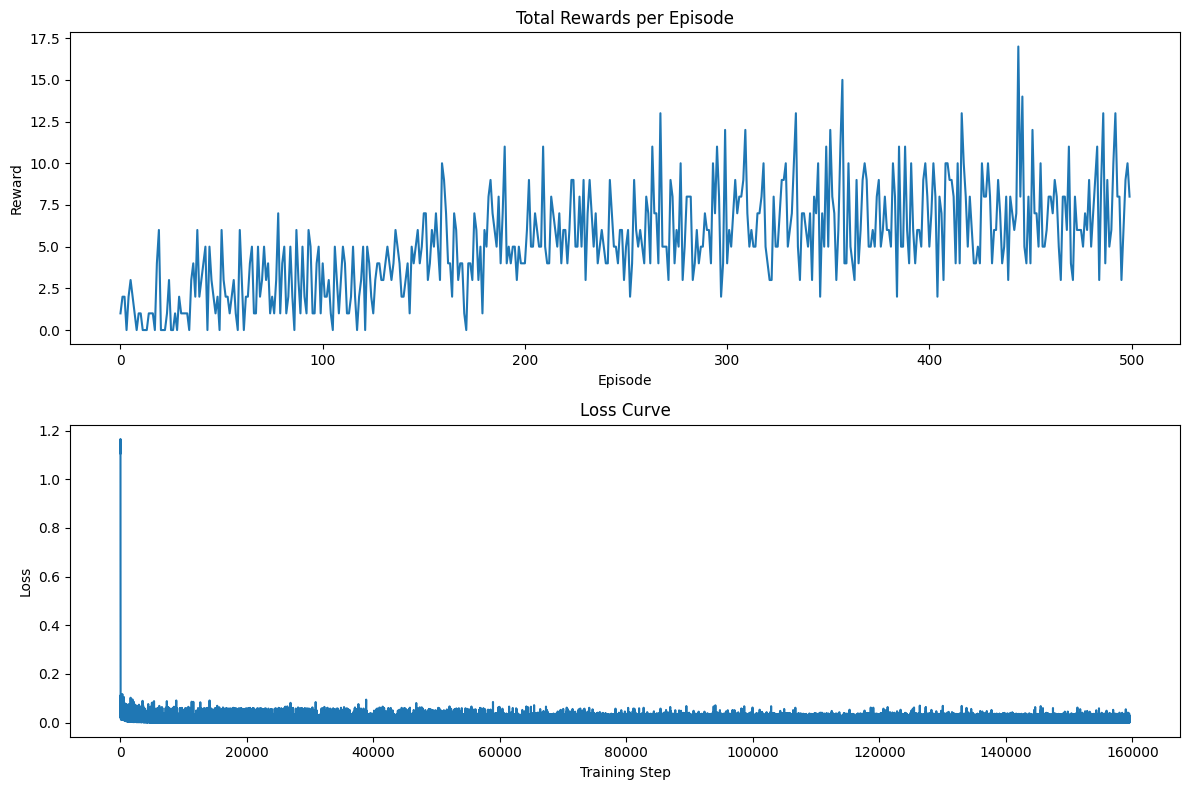

In [57]:
plot_training_results(rewards, losses)

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import os
from datetime import datetime
import ale_py
import shimmy

def visualize_state_values(agent, env_name="ALE/Breakout-v5", episodes=5, plot_q_values=True):
    env = gym.make(env_name, render_mode='rgb_array')
    all_q_peaks = []

    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"outputs/episode_visuals_{now}"
    os.makedirs(output_dir, exist_ok=True)

    for ep in range(episodes):
        screenshots = []

        state, _ = env.reset()
        state = preprocess_frame(state)
        state_stack = np.stack([state] * 4, axis=0)

        done = False
        q_values_episode = []

        while not done:
    
            frame = env.render()
            frame = np.asarray(frame, dtype=np.uint8)
            screenshots.append(frame)

     
            state_tensor = torch.tensor(state_stack, dtype=torch.float32, device=DEVICE).unsqueeze(0) / 255.0
            q_values = agent.eval_net(state_tensor).squeeze().cpu().detach().numpy()
            best_q = np.max(q_values)
            q_values_episode.append(best_q)

            # Шаг
            action = np.argmax(q_values)
            next_state_raw, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_state_processed = preprocess_frame(next_state_raw)
            state_stack = np.roll(state_stack, shift=-1, axis=0)
            state_stack[-1] = next_state_processed

        all_q_peaks.append(q_values_episode)


        video_path = os.path.join(output_dir, f"episode_{ep+1}.mp4")
        with imageio.get_writer(video_path, fps=15, codec='libx264') as writer:
            for frame in screenshots:
                writer.append_data(frame)
        print(f"Эпизод {ep+1} — видео сохранено: {video_path}")

    env.close()


    if plot_q_values:
        plt.figure(figsize=(12, 6))
        for idx, q_vals in enumerate(all_q_peaks):
            plt.plot(q_vals, label=f"Episode {idx+1}")
        plt.title("Q-value со временем")
        plt.xlabel("Step")
        plt.ylabel("Q-value")
        plt.grid(True)
        plt.tight_layout()
        plot_path = os.path.join(output_dir, "q_values_plot.png")
        plt.savefig(plot_path)
        plt.show()
        print(f"График Q-значений сохранён: {plot_path}")

    return all_q_peaks

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Эпизод 1 — видео сохранено: outputs/episode_visuals_20250424_134617\episode_1.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Эпизод 2 — видео сохранено: outputs/episode_visuals_20250424_134617\episode_2.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Эпизод 3 — видео сохранено: outputs/episode_visuals_20250424_134617\episode_3.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Эпизод 4 — видео сохранено: outputs/episode_visuals_20250424_134617\episode_4.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Эпизод 5 — видео сохранено: outputs/episode_visuals_20250424_134617\episode_5.mp4


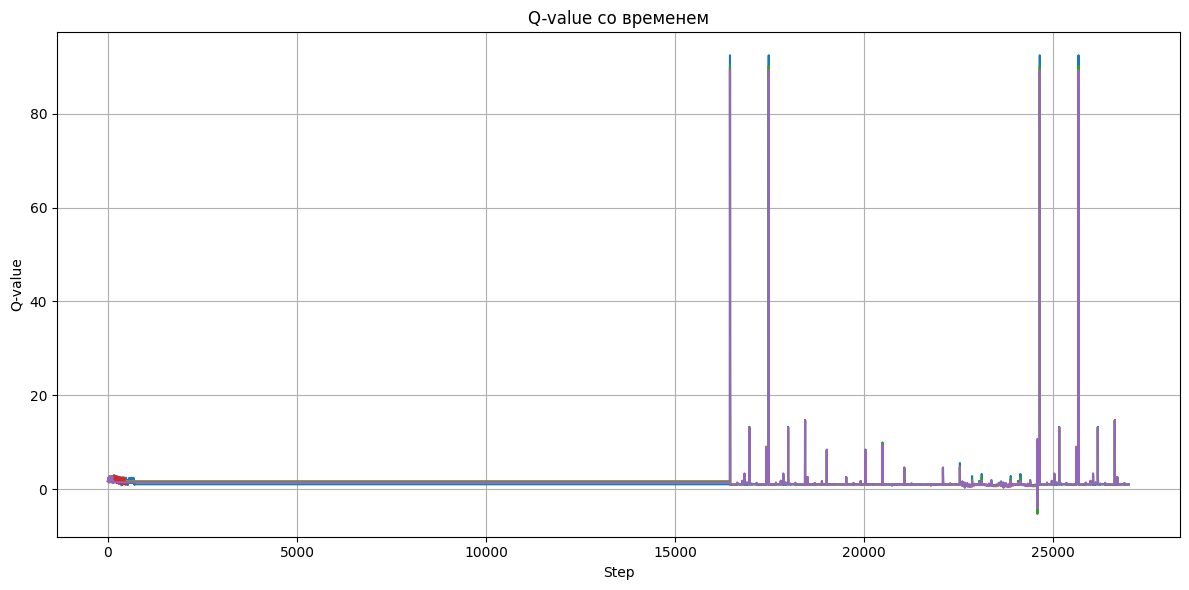

График Q-значений сохранён: outputs/episode_visuals_20250424_134617\q_values_plot.png


In [59]:
all_q_peaks = visualize_state_values(agent)